In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import math

from copy import deepcopy

In [2]:
class AMR():
    def __init__(self, _index, _speed):
        self.index = _index
        self.speed = _speed
        self.status = 0   # 0: idle status, 1: busy status
        self.path = []

    def FIFO(self, _materials):
        earliestReleaseTime = 99999999999
        earliestMaterialIndex = 9999
        for index, material in enumerate(_materials):
            if material.status == 0:
                if material.releaseTime < earliestReleaseTime:
                    earliestReleaseTime = material.releaseTime
                    earliestMaterialIndex = index
        return earliestMaterialIndex

    def EDD(self, _materials):
        earliestDueDate = 999999999999
        earliestMaterialIndex = 9999
        for index, material in enumerate(_materials):
            if material.status == 0: # material is unassigned
                if material.dueDate < earliestDueDate:
                    earliestDueDate = material.dueDate
                    earliestMaterialIndex = index
        return earliestMaterialIndex


    def SPT(self, _materials):
        shortestProcessTime = 999999999999
        shortestMaterialIndex = 99999
        for index, material in enumerate(_materials):
            if material.status == 0:
                if material.processTime < shortestProcessTime:
                    shortestProcessTime = material.processTime
                    shortestMaterialIndex = index
        return shortestMaterialIndex


    def LST(self, _materials):
        leastSlackTime = 9999999999
        leastSlackMaterialIndex = 99999
        currentTime = 0  # 현재 시간; 필요에 따라 업데이트해야 함

        for index, material in enumerate(_materials):
            if material.status == 0:  # 자재가 할당되지 않은 경우
                slackTime = (material.dueDate - currentTime) - material.processTime
                if slackTime < leastSlackTime:
                    leastSlackTime = slackTime
                    leastSlackMaterialIndex = index
        return leastSlackMaterialIndex

    def LPT(self, _materials):
        longestProcessTime = -9999999999
        longestMaterialIndex = -99999
        for index, material in enumerate(_materials):
            if material.status == 0:  # 자재가 할당되지 않은 경우
                if material.processTime > longestProcessTime:
                    longestProcessTime = material.processTime
                    longestMaterialIndex = index
        return longestMaterialIndex



    def InsertPath(self, _material):
        self.path.append(Node(_material.storage.location, _material, None, None)) # storage of _material
        self.path.append(Node(_material.workcenter.location, _material, None, None)) # workcenter of _material


    def Scheduling(self, currentTime):
        if len(self.path) > 2:
            self.path[-3].departureTime = currentTime
            self.path[-2].arrivalTime = round(self.path[-3].departureTime + self.GetTravelTime(self.path[-3].location, self.path[-2].location), 1)
            self.path[-2].departureTime = round(self.path[-2].arrivalTime + self.path[-2].material.processTime, 1)
            self.path[-1].arrivalTime = round(self.path[-2].departureTime + self.GetTravelTime(self.path[-2].location, self.path[-1].location), 1)
            self.path[-1].departureTime = round(self.path[-1].arrivalTime + self.path[-1].material.processTime, 1)
        else:
            self.path[-2].arrivalTime = currentTime
            self.path[-2].departureTime = round(self.path[-2].arrivalTime + self.path[-2].material.processTime, 1)
            self.path[-1].arrivalTime = round(self.path[-2].departureTime + self.GetTravelTime(self.path[-2].location, self.path[-1].location) , 1)
            self.path[-1].departureTime = round(self.path[-1].arrivalTime + self.path[-1].material.processTime, 1)

    def GetTravelTime(self, location1, location2):
        distance = math.sqrt((location1[0] - location2[0])**2 + (location1[1] - location2[1])**2)
        travelTime = distance / self.speed
        return travelTime

class Storage():
    def __init__(self, _index, _location):
        self.index = _index
        self.location = _location
        self.numUnAssignedMaterial = 0
        self.numUnAssignedMaterials = []
        self.interReleaseTimes = []
        self.elapsedTimes = []

class Workcenter():
    def __init__(self, _index, _location):
        self.index = _index
        self.location = _location

class Material():
    def __init__(self, _index, _releaseTime, _processTime, _dueDate, _storage, _workcenter):
        self.index = _index
        self.releaseTime = _releaseTime
        self.processTime = _processTime
        self.dueDate = _dueDate
        self.storage = _storage
        self.workcenter = _workcenter
        self.status = 0  # 0: unassigned, 1: assigned, 2: finished

class Node():
    def __init__(self, _location, _material, _arrivalTime, _departureTime):
        self.location = _location
        self.material = _material
        self.arrivalTime = _arrivalTime
        self.departureTime = _departureTime

class Chromosome():
    def __init__(self):
        self.genes = []
        self.fitnessValue = 0
        self.amr = None

def GetFitnessValue(amr, materials, chromosome):
    # initialize AMR
    amr.status = 0
    amr.path = []

    # initialize materials
    for material in materials:
        material.status = 0

    currentTime = 0
    geneIndex = 0

    while True:
        StatusUpdate(currentTime)
        if AllDone() == True:
            break

        for amr in amrs:
            if IsUnAssigned() == False: # there are no unassigned materials
                break
            if amr.status == 0:
                if chromosome.genes[geneIndex] == 0:
                    materialIndex = amr.FIFO(materials)
                elif chromosome.genes[geneIndex] == 1:
                    materialIndex = amr.EDD(materials)
                elif chromosome.genes[geneIndex] == 2:
                    materialIndex = amr.SPT(materials)
                elif chromosome.genes[geneIndex] == 3:
                    materialIndex = amr.LST(materials)
                elif chromosome.genes[geneIndex] == 4:
                    materialIndex = amr.LPT(materials)


                amr.InsertPath(materials[materialIndex])
                amr.Scheduling(currentTime)
                materials[materialIndex].status = 1   # assigned
                amr.status = 1 # busy
                geneIndex += 1

        currentTime = round(currentTime + 0.1, 1)


    chromosome.amr = deepcopy(amr)
    chromosome.fitnessValue = amr.path[-1].departureTime # makespan




#파라미터
numStorages = 3
numWorkcenters = 3
mapWidth = 25
mapHeight = 25

import random
random.seed(1234)

storages = []
storage = Storage(0, (1, 10))
storages.append(storage)
storage = Storage(1, (3, 20))
storages.append(storage)
storage = Storage(2, (4, 15))
storages.append(storage)


workcenters = []
workcenter = Workcenter(0, (24, 24))
workcenters.append(workcenter)
workcenter = Workcenter(1, (20, 0))
workcenters.append(workcenter)
workcenter = Workcenter(2, (15, 15))
workcenters.append(workcenter)


numMaterials = 30
maxReleaseTime = 1000
maxProcessTime = 10
minDueDate = 10
maxDueDate = 15

materials = []
for i in range(numMaterials):
    releaseTime = random.randint(0, maxReleaseTime)
    processTime = random.randint(0, maxProcessTime)
    dueDate = random.randint(minDueDate, maxDueDate)
    dueDate = releaseTime + dueDate
    storageIndex = random.randint(0, numStorages - 1)
    workcenterIndex = random.randint(0, numWorkcenters - 1)
    material = Material(i, releaseTime, processTime, dueDate, storages[storageIndex], workcenters[workcenterIndex])
    materials.append(material)

In [3]:
numAMRs = 5

amrs = []
for i in range(numAMRs):
    amr = AMR(i, 1)
    amrs.append(amr)


def StatusUpdate(currentTime):
    for amr in amrs:
        if len(amr.path) > 0:
            if round(amr.path[-1].arrivalTime + amr.path[-1].material.processTime, 1) <= currentTime:
                amr.status = 0
                amr.path[-1].material.status = 2

def AllDone():
    flag = True
    for material in materials:
        if material.status != 2:
            flag = False
            break
    return flag

def IsUnAssigned():
    flag = False
    for material in materials:
        if material.status == 0: # unAssigned
            flag = True
            break
    return flag


# generate new materials
materials = []
for i in range(numMaterials):
    releaseTime = random.randint(0, maxReleaseTime)
    processTime = random.randint(0, maxProcessTime)
    dueDate = random.randint(minDueDate, maxDueDate)
    dueDate = releaseTime + dueDate
    storageIndex = random.randint(0, numStorages - 1)
    workcenterIndex = random.randint(0, numWorkcenters - 1)
    material = Material(i, releaseTime, processTime, dueDate, storages[storageIndex], workcenters[workcenterIndex])
    materials.append(material)



initialPopulationSize = 20


chromosomes = []

for i in range(initialPopulationSize):

    chromosome = Chromosome()

    for j in range(numMaterials):
        # randomly select dispatching rule
        dispatchingRuleIndex = random.randint(0, 2)
        chromosome.genes.append(dispatchingRuleIndex)
    chromosomes.append(chromosome)


# generate path and calculate the fitness value
for chromosome in chromosomes:
    GetFitnessValue(amrs[0], materials, chromosome)

# Generation
maxGeneration = 20

for i in range(maxGeneration):
    # sort the chromosomes by fitness values
    chromosomes = sorted(chromosomes, key=lambda chromosome: chromosome.fitnessValue)

    # choose the best two chromosomes as parents
    chromosome_0 = deepcopy(chromosomes[0])
    chromosome_1 = deepcopy(chromosomes[1])

    # crossover
    # randomly swap 1 gene
    swapIndex = random.randint(0, len(chromosome_0.genes) - 1)

    tempGene = chromosome_0.genes[swapIndex]
    chromosome_0.genes[swapIndex] = chromosome_1.genes[swapIndex]
    chromosome_1.genes[swapIndex] = tempGene

    # generate path and calculate the fitness value
    GetFitnessValue(amrs[0], materials, chromosome_0)
    GetFitnessValue(amrs[0], materials, chromosome_1)

    # add to population
    chromosomes.append(chromosome_0)
    chromosomes.append(chromosome_1)


    # mutation
    mutatedChromosomeIndex = random.randint(0, len(chromosomes) - 1)
    mutatedChromosome = deepcopy(chromosomes[mutatedChromosomeIndex])
    mutatedGeneIndex_0 = random.randint(0, len(mutatedChromosome.genes) - 1)
    mutatedGeneIndex_1 = random.randint(0, len(mutatedChromosome.genes) - 1)


    tempGene = mutatedChromosome.genes[mutatedGeneIndex_0]
    mutatedChromosome.genes[mutatedGeneIndex_0] = mutatedChromosome.genes[mutatedGeneIndex_1]
    mutatedChromosome.genes[mutatedGeneIndex_1] = tempGene

    # generate path and calculate the fitness value
    GetFitnessValue(amrs[0], materials, mutatedChromosome)

    # add to the population
    chromosomes.append(mutatedChromosome)
    chromosomes = sorted(chromosomes, key=lambda chromosome: chromosome.fitnessValue)

    # remove the worst chromosomes
    del chromosomes[initialPopulationSize: len(chromosomes)]


# find the best 5 chromosomes
bestChromosomes = chromosomes[0:5]

In [4]:
responses=[]
feature1 = []

for chromosome in bestChromosomes:
    currentTime = 0

    # initialize AMR
    for amr in amrs:
        amr.status = 0 # idle
        amr.path = []

    # generate new materials
    materials = []
    for i in range(numMaterials):
        releaseTime = random.randint(0, maxReleaseTime)
        processTime = random.randint(0, maxProcessTime)
        dueDate = random.randint(minDueDate, maxDueDate)
        dueDate = releaseTime + dueDate
        storageIndex = random.randint(0, numStorages - 1)
        workcenterIndex = random.randint(0, numWorkcenters - 1)
        material = Material(i, releaseTime, processTime, dueDate, storages[storageIndex], workcenters[workcenterIndex])
        materials.append(material)


    while True:
        StatusUpdate(currentTime)
        if AllDone() == True:
            break

        for amr in amrs:
            if IsUnAssigned() == False: # there are no unassigned materials
                break
            if amr.status == 0:

                dispatchingRuleIndex = random.randint(0, 2)
                if dispatchingRuleIndex == 0:
                    materialIndex = amr.FIFO(materials)
                elif dispatchingRuleIndex == 1:
                    materialIndex = amr.EDD(materials)
                elif dispatchingRuleIndex == 2:
                    materialIndex = amr.SPT(materials)
                elif dispatchingRuleIndex == 3:
                    materialIndex = amr.LST(materials)
                elif dispatchingRuleIndex == 4:
                    materialIndex = amr.LPT(materials)

                # save the response
                if amr.index == 0:
                    responses.append(dispatchingRuleIndex)


                amr.InsertPath(materials[materialIndex])
                amr.Scheduling(currentTime)
                materials[materialIndex].status = 1   # assigned
                amr.status = 1

        currentTime = round(currentTime + 0.1, 1)



    # feature 1
    for index, node in enumerate(amrs[0].path):
        if index % 2 == 1: # node corresponding this index is work center
            departureTime_targetAMR = node.departureTime

            earliestReleaseTime = 999999999
            earliestReleaselocation = (0, 0)
            for i in range(0, len(amrs)):
                for j in range(len(amrs[i].path) - 1):
                    if j % 2 == 1: # amrs[i].path[j] is work center
                        if departureTime_targetAMR < amrs[i].path[j].departureTime:
                            if amrs[i].path[j+1].material.releaseTime <= departureTime_targetAMR:

                                if amrs[i].path[j+1].material.releaseTime < earliestReleaseTime:
                                    earliestReleaseTime = amrs[i].path[j+1].material.releaseTime
                                    earliestReleaseLocation = amrs[i].path[j+1].location
            if earliestReleaseTime != 999999999:
                distance = math.sqrt((earliestReleaseLocation[0] - node.location[0])**2 + (earliestReleaseLocation[1] - node.location[1])**2)
            else:
                distance = 0
            feature1.append(distance)


    # feature 2
    for index, node in enumerate(amrs[0].path):
        if index % 2 == 1: # node corresponding this index indicates the work center
            currentTime = node.departureTime

            for storage in storages:
                storage.numUnassignedMaterial = 0

            for i in range(0, len(amrs)):
                for j in range(len(amrs[i].path) - 1):
                    if j % 2 == 1: # work center
                        if currentTime < amrs[i].path[j].departureTime:
                            if amrs[i].path[j + 1].material.releaseTime <= currentTime:
                                amrs[i].path[j + 1].material.storage.numUnAssignedMaterial += 1
            for storage in storages:
                storage.numUnAssignedMaterials.append(storage.numUnAssignedMaterial)


    # feature 3
    for index, node in enumerate(amrs[0].path):
        if index % 2 == 1: # work center
            currentTime = node.departureTime
            for storage in storages:
                releaseTimes = []

                for material in materials:
                    if material.storage.index == storage.index and material.releaseTime <= currentTime:
                        releaseTimes.append(material.releaseTime)

                releaseTimes.sort()
                interReleaseTimes = []
                for index in range(len(releaseTimes) - 1):
                    interReleaseTimes.append(releaseTimes[index + 1] - releaseTimes[index])

                if interReleaseTimes:
                    interReleaseTimes = np.array(interReleaseTimes)
                    storage.interReleaseTimes.append(np.mean(interReleaseTimes))
                else:
                    storage.interReleaseTimes.append(0)


    # feature 4
    for storage in storages:
        releaseTimes = []
        for material in materials:
            if material.storage.index == storage.index:
                releaseTimes.append(material.releaseTime)
        releaseTimes.sort()

        for index, node in enumerate(amrs[0].path):
            if index % 2 == 1: # work center
                currentTime = node.departureTime

                elapsedTime = 0
                for releaseTime in releaseTimes:
                    if releaseTime <= currentTime:
                        elapsedTime = currentTime - releaseTime
                    else:
                        break
                storage.elapsedTimes.append(elapsedTime)

# make pandas dataframe
data = pd.DataFrame({"feature1": feature1, 'feature2_0': storages[0].numUnAssignedMaterials, 'feature2_1': storages[1].numUnAssignedMaterials, 'feature2_2': storages[2].numUnAssignedMaterials,
                     'feature3_0': storages[0].interReleaseTimes, 'feature3_1': storages[1].interReleaseTimes, 'feature3_2': storages[2].interReleaseTimes, 'feature4_0': storages[0].elapsedTimes,
                     'feature4_1': storages[1].elapsedTimes, 'feature4_2': storages[2].elapsedTimes, 'response': responses})

X = data.drop(['response'], axis=1)
y = data['response']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

In [5]:
from xgboost import XGBClassifier
import xgboost

dtrain = xgboost.DMatrix(data=X_train, label = y_train)
dtest = xgboost.DMatrix(data=X_test, label=y_test)

params = {'max_depth' : 3,
         'eta' : 0.1,
         'eval_metric' : 'logloss',
         'early_stoppings' : 100 }

num_rounds = 400
wlist = [(dtrain, 'train'), (dtest,'eval')]
xgb= xgboost.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[08:16:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stoppings" } are not used.

[0]	train-logloss:0.50150	eval-logloss:0.68919
[1]	train-logloss:0.32299	eval-logloss:0.70761
[2]	train-logloss:0.13702	eval-logloss:0.73243
[3]	train-logloss:-0.10445	eval-logloss:0.81462
[4]	train-logloss:-0.81731	eval-logloss:1.11918
[5]	train-logloss:-7.10724	eval-logloss:4.58679
[6]	train-logloss:-7.16156	eval-logloss:4.62441
[7]	train-logloss:-7.23642	eval-logloss:4.58240
[8]	train-logloss:-7.29106	eval-logloss:4.65765
[9]	train-logloss:-7.33308	eval-logloss:4.61453
[10]	train-logloss:-7.46232	eval-logloss:4.57637
[11]	train-logloss:-9.11609	eval-logloss:4.75061
[12]	train-logloss:-9.15057	eval-logloss:4.68287
[13]	train-logloss:-9.20055	eval-logloss:8.42908
[14]	train-logloss:-9.26098	eval-logloss:8.49779
[15]	train-logloss:-9.32253	eval-logloss:8.56948
[16]	train-logloss:-10.9

[157]	train-logloss:-11.36380	eval-logloss:12.53218
[158]	train-logloss:-11.36395	eval-logloss:12.53241
[159]	train-logloss:-11.36407	eval-logloss:12.53310
[160]	train-logloss:-11.36428	eval-logloss:12.53419
[161]	train-logloss:-11.36460	eval-logloss:12.53376
[162]	train-logloss:-11.36473	eval-logloss:12.53347
[163]	train-logloss:-11.36489	eval-logloss:12.53312
[164]	train-logloss:-11.36500	eval-logloss:12.53284
[165]	train-logloss:-11.36508	eval-logloss:12.53306
[166]	train-logloss:-11.36521	eval-logloss:12.53378
[167]	train-logloss:-11.36551	eval-logloss:12.53479
[168]	train-logloss:-11.36562	eval-logloss:12.53506
[169]	train-logloss:-11.36582	eval-logloss:12.53531
[170]	train-logloss:-11.36590	eval-logloss:12.53551
[171]	train-logloss:-11.36601	eval-logloss:12.53616
[172]	train-logloss:-11.36627	eval-logloss:12.53703
[173]	train-logloss:-11.36645	eval-logloss:12.53722
[174]	train-logloss:-11.36646	eval-logloss:12.53747
[175]	train-logloss:-11.36670	eval-logloss:12.53711
[176]	train-

[315]	train-logloss:-11.37212	eval-logloss:12.54876
[316]	train-logloss:-11.37212	eval-logloss:12.54876
[317]	train-logloss:-11.37212	eval-logloss:12.54876
[318]	train-logloss:-11.37212	eval-logloss:12.54876
[319]	train-logloss:-11.37212	eval-logloss:12.54876
[320]	train-logloss:-11.37212	eval-logloss:12.54876
[321]	train-logloss:-11.37212	eval-logloss:12.54876
[322]	train-logloss:-11.37212	eval-logloss:12.54876
[323]	train-logloss:-11.37212	eval-logloss:12.54876
[324]	train-logloss:-11.37212	eval-logloss:12.54876
[325]	train-logloss:-11.37212	eval-logloss:12.54876
[326]	train-logloss:-11.37212	eval-logloss:12.54876
[327]	train-logloss:-11.37212	eval-logloss:12.54876
[328]	train-logloss:-11.37212	eval-logloss:12.54876
[329]	train-logloss:-11.37212	eval-logloss:12.54876
[330]	train-logloss:-11.37212	eval-logloss:12.54876
[331]	train-logloss:-11.37212	eval-logloss:12.54876
[332]	train-logloss:-11.37212	eval-logloss:12.54876
[333]	train-logloss:-11.37212	eval-logloss:12.54876
[334]	train-

In [6]:
'''
# Set data types for categorical labels
from tensorflow.keras import utils
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)


# Define a classifier network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
hl = 1 # number of hidden layer nodes

model = Sequential()
model.add(Dense(hl, input_dim = X_train.shape[1], activation='relu'))
model.add(Dense(hl, input_dim = hl, activation='relu'))
model.add(Dense(y_train.shape[1], input_dim = hl, activation='softmax'))



# Train the model
# hyper parameters for optimizer
from tensorflow.keras import optimizers

opt = optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Train the model over 50 epochs using 10-observation batches
num_epochs = 50
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=10, validation_data=(X_test, y_test))
'''

"\n# Set data types for categorical labels\nfrom tensorflow.keras import utils\ny_train = utils.to_categorical(y_train)\ny_test = utils.to_categorical(y_test)\n\n\n# Define a classifier network\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense\nhl = 1 # number of hidden layer nodes\n\nmodel = Sequential()\nmodel.add(Dense(hl, input_dim = X_train.shape[1], activation='relu'))\nmodel.add(Dense(hl, input_dim = hl, activation='relu'))\nmodel.add(Dense(y_train.shape[1], input_dim = hl, activation='softmax'))\n\n\n\n# Train the model\n# hyper parameters for optimizer\nfrom tensorflow.keras import optimizers\n\nopt = optimizers.Adam(learning_rate=0.001)\n\nmodel.compile(loss='categorical_crossentropy',\n              optimizer=opt,\n              metrics=['accuracy'])\n\n# Train the model over 50 epochs using 10-observation batches\nnum_epochs = 50\nhistory = model.fit(X_train, y_train, epochs=num_epochs, batch_size=10, validation_data=(X_test, y_test)

In [7]:
# generate new materials (to make a variety of training instances)

materials = []
for i in range(numMaterials):
    releaseTime = random.randint(0, maxReleaseTime)
    processTime = random.randint(0, maxProcessTime)
    dueDate = random.randint(minDueDate, maxDueDate)
    dueDate = releaseTime + dueDate
    storageIndex = random.randint(0, len(storages) - 1)
    workcenterIndex = random.randint(0, len(workcenters) - 1)
    material = Material(i, releaseTime, processTime, dueDate, storages[storageIndex], workcenters[workcenterIndex])
    materials.append(material)


result_FIFO = 0
result_EDD = 0
result_SPT = 0
result_LST = 0
result_LPT = 0
result_ML = 0

In [8]:
max_case = 6

for case in range(max_case):
    currentTime = 0

    # initialize AMR
    for amr in amrs:
        amr.status = 0
        amr.path = []

    # initialize the statsu of materials
    for material in materials:
        material.status = 0

    while True:
        StatusUpdate(currentTime)
        if AllDone() == True:
            break

        for amr in amrs:
            if IsUnAssigned() == False: # there are no unassigned materials
                break

            if amr.status == 0:
                # Dispatching rule

                if case == 0:
                    materialIndex = amr.FIFO(materials)
                elif case == 1:
                    materialIndex = amr.EDD(materials)
                elif case == 2:
                    materialIndex = amr.SPT(materials)
                elif case == 3:
                    materialIndex = amr.LST(materials)
                elif case == 4:
                    materialIndex = amr.LPT(materials)
                elif case ==5:
                    # initialize features
                    feature1 = []
                    for storage in storages:
                        storage.numUnAssignedMaterial = 0
                        storage.numUnAssignedMaterials = []
                        storage.interReleaseTimes = []
                        storage.elapsedTimes = []


                    departureTime_targetAMR = currentTime

                    # Feature 1: Distance between target AMR and storage where the unassigned material is held
                    earliestReleaseTime = 999999
                    earliestReleaselocation = (0, 0)
                    for material in materials:
                        if material.releaseTime < earliestReleaseTime:
                            earliestReleaseTime = material.releaseTime
                            earliestReleaselocation = material.storage.location

                    if len(amr.path) == 0:
                        distance = 0.0
                    else:
                        distance = math.sqrt((amr.path[-1].location[0] - earliestReleaselocation[0])**2 + (amr.path[-1].location[1] - earliestReleaselocation[1])**2)
                    feature1.append(distance)




                    # Feature 2: The number of currently unassigned materials at each storage
                    for material in materials:
                        if material.status == 0:
                            material.storage.numUnAssignedMaterial += 1

                    for storage in storages:
                        storage.numUnAssignedMaterials.append(storage.numUnAssignedMaterial)


                    # Feature 3: Average inter-release time of materials at each storage
                    for storage in storages:
                        releaseTimes = []

                        for material in materials:
                            if material.storage.index == storage.index and material.releaseTime <= currentTime:
                                releaseTimes.append(material.releaseTime)

                        releaseTimes.sort()
                        interReleaseTimes = []
                        for index in range(len(releaseTimes) - 1):
                            interReleaseTimes.append(releaseTimes[index + 1] - releaseTimes[index])

                        if interReleaseTimes:
                            interReleaseTimes = np.array(interReleaseTimes)
                            storage.interReleaseTimes.append(np.mean(interReleaseTimes))
                        else:
                            storage.interReleaseTimes.append(0)

                        # Feature 4: Elapsed time since the last released material at each storage
                        elapsedTime = 0
                        for releaseTime in releaseTimes:
                            if releaseTime <= departureTime_targetAMR:
                                elapsedTime = departureTime_targetAMR - releaseTime
                            else:
                                break

                        storage.elapsedTimes.append(elapsedTime)


                    # make pandas dataframe
                    X_new = pd.DataFrame({"feature1": feature1, 'feature2_0': storages[0].numUnAssignedMaterials, 'feature2_1': storages[1].numUnAssignedMaterials, 'feature2_2': storages[2].numUnAssignedMaterials,
                     'feature3_0': storages[0].interReleaseTimes, 'feature3_1': storages[1].interReleaseTimes, 'feature3_2': storages[2].interReleaseTimes, 'feature4_0': storages[0].elapsedTimes,
                     'feature4_1': storages[1].elapsedTimes, 'feature4_2': storages[2].elapsedTimes})

                    X_new = xgboost.DMatrix(data=X_new)
                    class_probabilities = xgb.predict(X_new)
                    predicionts = np.argmax(class_probabilities)


                    if predicionts == 0:
                        materialIndex = amr.FIFO(materials)
                    elif predicionts == 1:
                        materialIndex = amr.EDD(materials)
                    elif predicionts == 2:
                        materialIndex = amr.SPT(materials)
                    elif predicionts == 3:
                        materialIndex = amr.LST(materials)
                    elif predicionts == 4:
                        materialIndex = amr.LPT(materials)


                amr.InsertPath(materials[materialIndex])
                amr.Scheduling(currentTime)
                materials[materialIndex].status = 1
                amr.status = 1

        currentTime = round(currentTime + 0.1, 1)

    # performance
    makeSpan = 0
    totalTardiness = 0
    for amr in amrs:
        if len(amr.path) > 0:
            # makespan
            if makeSpan < amr.path[-1].departureTime:
                makeSpan = amr.path[-1].departureTime

        for index, node in enumerate(amr.path):
            if index % 2 == 1:
                totalTardiness += max(node.arrivalTime + node.material.processTime - node.material.dueDate, 0)

    if case == 0:
        result_FIFO = totalTardiness
    elif case == 1:
        result_EDD = totalTardiness
    elif case == 2:
        result_SPT = totalTardiness
    elif case == 3:
        result_LST = totalTardiness
    elif case == 4:
        result_LPT = totalTardiness
    elif case == 5:
        result_ML = totalTardiness


print('totalTardiness (FIFO): ' + str(result_FIFO))
print('totalTardiness (EDD): ' + str(result_EDD))
print('totalTardiness (SPT): ' + str(result_SPT))
print('totalTardiness (LST): ' + str(result_LST))
print('totalTardiness (LPT): ' + str(result_LPT))
print('totalTardiness (ML): ' + str(result_ML))

totalTardiness (FIFO): 1.8999999999999986
totalTardiness (EDD): 1.8999999999999986
totalTardiness (SPT): 658.6999999999999
totalTardiness (LST): 1.8999999999999986
totalTardiness (LPT): 875.8
totalTardiness (ML): 1.8999999999999986


In [9]:
# csv file export
AMRs_indices = []
AMRs_currentLocations_x = []
AMRs_currentLocations_y = []
AMRs_currentTimes = []
for amr in amrs:
    indices = []
    currentLocations_x = []
    currentLocations_y = []
    currentTimes = []


    currentTime = 0
    while True:
        for i in range(len(amr.path) - 1):
            if round(amr.path[i].arrivalTime, 1) <= currentTime <= round(amr.path[i].departureTime, 1):
                indices.append(amr.index)
                currentTimes.append(currentTime)
                currentLocations_x.append(amr.path[i].location[0])
                currentLocations_y.append(amr.path[i].location[1])


            elif round(amr.path[i].departureTime, 1) < currentTime < round(amr.path[i + 1].arrivalTime, 1):
                indices.append(amr.index)
                currentTimes.append(currentTime)
                travelTimeBtwNextAndPrev = amr.path[i + 1].arrivalTime - amr.path[i].departureTime
                travelTimeBtwCurrentAndPrev = currentTime - amr.path[i].departureTime
                ratio = travelTimeBtwCurrentAndPrev / travelTimeBtwNextAndPrev

                directionVector = (amr.path[i + 1].location[0] - amr.path[i].location[0], amr.path[i + 1].location[1] - amr.path[i].location[1])

                currentLocations_x.append(amr.path[i].location[0] + (directionVector[0] * ratio))
                currentLocations_y.append(amr.path[i].location[1] + (directionVector[1] * ratio))

        currentTime = round(currentTime + 0.1, 1)

        if currentTime == round(amr.path[-1].arrivalTime, 1):
            indices.append(amr.index)
            currentTimes.append(currentTime)
            currentLocations_x.append(amr.path[-1].location[0])
            currentLocations_y.append(amr.path[-1].location[1])
            break

    AMRs_indices.extend(indices)
    AMRs_currentLocations_x.extend(currentLocations_x)
    AMRs_currentLocations_y.extend(currentLocations_y)
    AMRs_currentTimes.extend(currentTimes)


# make pandas dataframe
result = pd.DataFrame({"amrIndex": AMRs_indices, 'location_x': AMRs_currentLocations_x, 'location_y': AMRs_currentLocations_y, 'currentTime': AMRs_currentTimes})
'''
result.to_csv('mycsvfile.csv',index=False)
print('end')
'''

"\nresult.to_csv('mycsvfile.csv',index=False)\nprint('end')\n"

In [10]:
for i in range(len(result['amrIndex'].unique())):
     globals()['df{}'.format(str(i))] = result[result['amrIndex']==i]

In [12]:
if len(result['amrIndex'].unique()) == 1:
    dist0 = []
    for j in range(len(df0)-1):
        dist0.append(np.sqrt((df0['location_x'][j+1]-df0['location_x'][j])**2 + (df0['location_y'][j+1]-df0['location_y'][j])**2))
    amr_dist1 = sum(dist0)
    meter1_distance = amr_dist1*(2*result['currentTime'].max()/amr_dist1)
    
elif len(result['amrIndex'].unique()) == 2:
    df1 = df1.reset_index().drop('index',axis=1)
    dist0 = []
    dist1 = []
    for j in range(len(df0)-1):
        dist0.append(np.sqrt((df0['location_x'][j+1]-df0['location_x'][j])**2 + (df0['location_y'][j+1]-df0['location_y'][j])**2))
    for j in range(len(df1)-1):
        dist1.append(np.sqrt((df1['location_x'][j+1]-df1['location_x'][j])**2 + (df1['location_y'][j+1]-df1['location_y'][j])**2))
    amr_dist2 = sum(dist0) + sum(dist1)
    meter2_distance = amr_dist2*(2*result['currentTime'].max()/amr_dist2)
    
elif len(result['amrIndex'].unique()) == 3:
    df1 = df1.reset_index().drop('index',axis=1)
    df2 = df2.reset_index().drop('index',axis=1)
    dist0 = []
    dist1 = []
    dist2 = []
    for j in range(len(df0)-1):
        dist0.append(np.sqrt((df0['location_x'][j+1]-df0['location_x'][j])**2 + (df0['location_y'][j+1]-df0['location_y'][j])**2))
    for j in range(len(df1)-1):
        dist1.append(np.sqrt((df1['location_x'][j+1]-df1['location_x'][j])**2 + (df1['location_y'][j+1]-df1['location_y'][j])**2))
    for j in range(len(df2)-1):
        dist2.append(np.sqrt((df2['location_x'][j+1]-df2['location_x'][j])**2 + (df2['location_y'][j+1]-df2['location_y'][j])**2))
    amr_dist3 = sum(dist0) + sum(dist1) + sum(dist2)
    meter3_distance = amr_dist3*(2*result['currentTime'].max()/amr_dist3)
    
elif len(result['amrIndex'].unique()) == 4:
    df1 = df1.reset_index().drop('index',axis=1)
    df2 = df2.reset_index().drop('index',axis=1)
    df3 = df3.reset_index().drop('index',axis=1)
    dist0 = []
    dist1 = []
    dist2 = []
    dist3 = []
    for j in range(len(df0)-1):
        dist0.append(np.sqrt((df0['location_x'][j+1]-df0['location_x'][j])**2 + (df0['location_y'][j+1]-df0['location_y'][j])**2))
    for j in range(len(df1)-1):
        dist1.append(np.sqrt((df1['location_x'][j+1]-df1['location_x'][j])**2 + (df1['location_y'][j+1]-df1['location_y'][j])**2))
    for j in range(len(df2)-1):
        dist2.append(np.sqrt((df2['location_x'][j+1]-df2['location_x'][j])**2 + (df2['location_y'][j+1]-df2['location_y'][j])**2))
    for j in range(len(df2)-1):
        dist3.append(np.sqrt((df3['location_x'][j+1]-df3['location_x'][j])**2 + (df3['location_y'][j+1]-df3['location_y'][j])**2))
    amr_dist4 = sum(dist0) + sum(dist1) + sum(dist2) + sum(dist3)
    meter4_distance = amr_dist4*(2*result['currentTime'].max()/amr_dist4)
    
elif len(result['amrIndex'].unique()) == 5:
    df1 = df1.reset_index().drop('index',axis=1)
    df2 = df2.reset_index().drop('index',axis=1)
    df3 = df3.reset_index().drop('index',axis=1)
    df4 = df4.reset_index().drop('index',axis=1)
    dist0 = []
    dist1 = []
    dist2 = []
    dist3 = []
    dist3 = []
    dist4 = []
    for j in range(len(df0)-1):
        dist0.append(np.sqrt((df0['location_x'][j+1]-df0['location_x'][j])**2 + (df0['location_y'][j+1]-df0['location_y'][j])**2))
    for j in range(len(df1)-1):
        dist1.append(np.sqrt((df1['location_x'][j+1]-df1['location_x'][j])**2 + (df1['location_y'][j+1]-df1['location_y'][j])**2))
    for j in range(len(df2)-1):
        dist2.append(np.sqrt((df2['location_x'][j+1]-df2['location_x'][j])**2 + (df2['location_y'][j+1]-df2['location_y'][j])**2))
    for j in range(len(df3)-1):
        dist3.append(np.sqrt((df3['location_x'][j+1]-df3['location_x'][j])**2 + (df3['location_y'][j+1]-df3['location_y'][j])**2))
    for j in range(len(df4)-1):
        dist4.append(np.sqrt((df4['location_x'][j+1]-df4['location_x'][j])**2 + (df4['location_y'][j+1]-df4['location_y'][j])**2)) 
    amr_dist5 = sum(dist0) + sum(dist1) + sum(dist2) + sum(dist3) + sum(dist4)
    meter5_distance = amr_dist5*(2*result['currentTime'].max()/amr_dist5)

cost = meter5_distance/100000000 * 20000 * len(result['amrIndex'].unique())
print(cost)

0.6517999999999999


<AxesSubplot:>

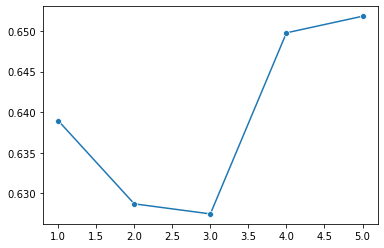

In [22]:
#saved value
import seaborn as sns
index = [i+1 for i in range(5)]
value = [0.63896,0.6287200000000001,0.6274799999999999,0.6497600000000001,0.6517999999999999]

sns.lineplot(x=index,y=value,marker='o')

## adam

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))  # 5 output classes corresponding to the dispatching rules


model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

# Predict using the trained model
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

materials = []
for i in range(numMaterials):
    releaseTime = random.randint(0, maxReleaseTime)
    processTime = random.randint(0, maxProcessTime)
    dueDate = random.randint(minDueDate, maxDueDate)
    dueDate = releaseTime + dueDate
    storageIndex = random.randint(0, len(storages) - 1)
    workcenterIndex = random.randint(0, len(workcenters) - 1)
    material = Material(i, releaseTime, processTime, dueDate, storages[storageIndex], workcenters[workcenterIndex])
    materials.append(material)

# Initialize results
result_FIFO = 0
result_EDD = 0
result_SPT = 0
result_LST = 0
result_LPT = 0
result_ML = 0


In [52]:

max_case = 6

for case in range(max_case):
    currentTime = 0

    # Initialize AMR
    for amr in amrs:
        amr.status = 0
        amr.path = []

    # Initialize the status of materials
    for material in materials:
        material.status = 0

    while True:
        StatusUpdate(currentTime)
        if AllDone() == True:
            break

        for amr in amrs:
            if IsUnAssigned() == False: # There are no unassigned materials
                break

            if amr.status == 0:
                # Dispatching rule
                if case == 0:
                    materialIndex = amr.FIFO(materials)
                elif case == 1:
                    materialIndex = amr.EDD(materials)
                elif case == 2:
                    materialIndex = amr.SPT(materials)
                elif case == 3:
                    materialIndex = amr.LST(materials)
                elif case == 4:
                    materialIndex = amr.LPT(materials)
                elif case == 5:
                    # Initialize features
                    feature1 = []
                    for storage in storages:
                        storage.numUnAssignedMaterial = 0
                        storage.numUnAssignedMaterials = []
                        storage.interReleaseTimes = []
                        storage.elapsedTimes = []

                    departureTime_targetAMR = currentTime

                    # Feature 1: Distance between target AMR and storage where the unassigned material is held
                    earliestReleaseTime = 999999
                    earliestReleaselocation = (0, 0)
                    for material in materials:
                        if material.releaseTime < earliestReleaseTime:
                            earliestReleaseTime = material.releaseTime
                            earliestReleaselocation = material.storage.location

                    if len(amr.path) == 0:
                        distance = 0.0
                    else:
                        distance = math.sqrt((amr.path[-1].location[0] - earliestReleaselocation[0])**2 + (amr.path[-1].location[1] - earliestReleaselocation[1])**2)
                    feature1.append(distance)

                    # Feature 2: The number of currently unassigned materials at each storage
                    for material in materials:
                        if material.status == 0:
                            material.storage.numUnAssignedMaterial += 1

                    for storage in storages:
                        storage.numUnAssignedMaterials.append(storage.numUnAssignedMaterial)

                    # Feature 3: Average inter-release time of materials at each storage
                    for storage in storages:
                        releaseTimes = []

                        for material in materials:
                            if material.storage.index == storage.index and material.releaseTime <= currentTime:
                                releaseTimes.append(material.releaseTime)

                        releaseTimes.sort()
                        interReleaseTimes = []
                        for index in range(len(releaseTimes) - 1):
                            interReleaseTimes.append(releaseTimes[index + 1] - releaseTimes[index])

                        if interReleaseTimes:
                            interReleaseTimes = np.array(interReleaseTimes)
                            storage.interReleaseTimes.append(np.mean(interReleaseTimes))
                        else:
                            storage.interReleaseTimes.append(0)

                        # Feature 4: Elapsed time since the last released material at each storage
                        elapsedTime = 0
                        for releaseTime in releaseTimes:
                            if releaseTime <= departureTime_targetAMR:
                                elapsedTime = departureTime_targetAMR - releaseTime
                            else:
                                break

                        storage.elapsedTimes.append(elapsedTime)

                    # Make pandas dataframe
                    X_new = pd.DataFrame({"feature1": feature1, 'feature2_0': storages[0].numUnAssignedMaterials, 'feature2_1': storages[1].numUnAssignedMaterials, 'feature2_2': storages[2].numUnAssignedMaterials,
                                         'feature3_0': storages[0].interReleaseTimes, 'feature3_1': storages[1].interReleaseTimes, 'feature3_2': storages[2].interReleaseTimes, 'feature4_0': storages[0].elapsedTimes,
                                         'feature4_1': storages[1].elapsedTimes, 'feature4_2': storages[2].elapsedTimes})

                    # Predict dispatching rule
                    class_probabilities = model.predict(X_new)
                    predictions = np.argmax(class_probabilities, axis=1)

                    if predictions == 0:
                        materialIndex = amr.FIFO(materials)
                    elif predictions == 1:
                        materialIndex = amr.EDD(materials)
                    elif predictions == 2:
                        materialIndex = amr.SPT(materials)
                    elif predictions == 3:
                        materialIndex = amr.LST(materials)
                    elif predictions == 4:
                        materialIndex = amr.LPT(materials)

                amr.InsertPath(materials[materialIndex])
                amr.Scheduling(currentTime)
                materials[materialIndex].status = 1
                amr.status = 1

        currentTime = round(currentTime + 0.1, 1)

    # Performance
    makeSpan = 0
    totalTardiness = 0
    for amr in amrs:
        if len(amr.path) > 0:
            # Makespan
            if makeSpan < amr.path[-1].departureTime:
                makeSpan = amr.path[-1].departureTime

        for index, node in enumerate(amr.path):
            if index % 2 == 1:
                totalTardiness += max(node.arrivalTime + node.material.processTime - node.material.dueDate, 0)

    if case == 0:
        result_FIFO = totalTardiness
    elif case == 1:
        result_EDD = totalTardiness
    elif case == 2:
        result_SPT = totalTardiness
    elif case == 3:
        result_LST = totalTardiness
    elif case == 4:
        result_LPT = totalTardiness
    elif case == 5:
        result_ML = totalTardiness

print('totalTardiness (FIFO): ' + str(result_FIFO))
print('totalTardiness (EDD): ' + str(result_EDD))
print('totalTardiness (SPT): ' + str(result_SPT))
print('totalTardiness (LST): ' + str(result_LST))
print('totalTardiness (LPT): ' + str(result_LPT))
print('totalTardiness (ML): ' + str(result_ML))


1/1 [==============================] - 0s 24ms/step
totalTardiness (FIFO): 287.90000000000003
totalTardiness (EDD): 287.9
totalTardiness (SPT): 3531.6000000000004
totalTardiness (LST): 287.9
totalTardiness (LPT): 4312.3
totalTardiness (ML): 1630.0000000000002


## Adagrad

In [44]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adagrad

In [45]:
# Adagrad 모델 생성 및 훈련
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

optimizer = Adagrad(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# 시뮬레이션 코드
max_case = 6

for case in range(max_case):
    currentTime = 0

    # initialize AMR
    for amr in amrs:
        amr.status = 0
        amr.path = []

    # initialize the status of materials
    for material in materials:
        material.status = 0

    while True:
        StatusUpdate(currentTime)
        if AllDone():
            break

        for amr in amrs:
            if not IsUnAssigned():
                break

            if amr.status == 0:
                # Dispatching rule
                if case in range(5):
                    if case == 0:
                        materialIndex = amr.FIFO(materials)
                    elif case == 1:
                        materialIndex = amr.EDD(materials)
                    elif case == 2:
                        materialIndex = amr.SPT(materials)
                    elif case == 3:
                        materialIndex = amr.LST(materials)
                    elif case == 4:
                        materialIndex = amr.LPT(materials)
                elif case == 5:
                    # Feature extraction
                    feature1 = []
                    for storage in storages:
                        storage.numUnAssignedMaterial = 0
                        storage.numUnAssignedMaterials = []
                        storage.interReleaseTimes = []
                        storage.elapsedTimes = []

                    departureTime_targetAMR = currentTime

                    earliestReleaseTime = float('inf')
                    earliestReleaselocation = (0, 0)
                    for material in materials:
                        if material.releaseTime < earliestReleaseTime:
                            earliestReleaseTime = material.releaseTime
                            earliestReleaselocation = material.storage.location

                    if len(amr.path) == 0:
                        distance = 0.0
                    else:
                        distance = math.sqrt((amr.path[-1].location[0] - earliestReleaselocation[0])**2 + (amr.path[-1].location[1] - earliestReleaselocation[1])**2)
                    feature1.append(distance)

                    for material in materials:
                        if material.status == 0:
                            material.storage.numUnAssignedMaterial += 1

                    for storage in storages:
                        storage.numUnAssignedMaterials.append(storage.numUnAssignedMaterial)

                    for storage in storages:
                        releaseTimes = [m.releaseTime for m in materials if m.storage.index == storage.index and m.releaseTime <= currentTime]
                        releaseTimes.sort()
                        interReleaseTimes = [releaseTimes[i + 1] - releaseTimes[i] for i in range(len(releaseTimes) - 1)]

                        if interReleaseTimes:
                            storage.interReleaseTimes.append(np.mean(interReleaseTimes))
                        else:
                            storage.interReleaseTimes.append(0)

                        elapsedTime = 0
                        for releaseTime in releaseTimes:
                            if releaseTime <= departureTime_targetAMR:
                                elapsedTime = departureTime_targetAMR - releaseTime
                            else:
                                break

                        storage.elapsedTimes.append(elapsedTime)

                    # Make pandas dataframe
                    X_new = pd.DataFrame({"feature1": feature1, 'feature2_0': storages[0].numUnAssignedMaterials, 'feature2_1': storages[1].numUnAssignedMaterials, 'feature2_2': storages[2].numUnAssignedMaterials,
                                          'feature3_0': storages[0].interReleaseTimes, 'feature3_1': storages[1].interReleaseTimes, 'feature3_2': storages[2].interReleaseTimes, 'feature4_0': storages[0].elapsedTimes,
                                          'feature4_1': storages[1].elapsedTimes, 'feature4_2': storages[2].elapsedTimes})

                    X_new = scaler.transform(X_new)
                    predictions = model.predict(X_new)
                    predicted_class = np.argmax(predictions, axis=1)[0]

                    if predicted_class == 0:
                        materialIndex = amr.FIFO(materials)
                    elif predicted_class == 1:
                        materialIndex = amr.EDD(materials)
                    elif predicted_class == 2:
                        materialIndex = amr.SPT(materials)
                    elif predicted_class == 3:
                        materialIndex = amr.LST(materials)
                    elif predicted_class == 4:
                        materialIndex = amr.LPT(materials)

                amr.InsertPath(materials[materialIndex])
                amr.Scheduling(currentTime)
                materials[materialIndex].status = 1
                amr.status = 1

        currentTime = round(currentTime + 0.1, 1)

    # Performance evaluation
    makeSpan = 0
    totalTardiness = 0
    for amr in amrs:
        if len(amr.path) > 0:
            if makeSpan < amr.path[-1].departureTime:
                makeSpan = amr.path[-1].departureTime

        for index, node in enumerate(amr.path):
            if index % 2 == 1:
                totalTardiness += max(node.arrivalTime + node.material.processTime - node.material.dueDate, 0)

    if case == 0:
        result_FIFO = totalTardiness
    elif case == 1:
        result_EDD = totalTardiness
    elif case == 2:
        result_SPT = totalTardiness
    elif case == 3:
        result_LST = totalTardiness
    elif case == 4:
        result_LPT = totalTardiness
    elif case == 5:
        result_ML = totalTardiness

print('totalTardiness (FIFO): ' + str(result_FIFO))
print('totalTardiness (EDD): ' + str(result_EDD))
print('totalTardiness (SPT): ' + str(result_SPT))
print('totalTardiness (LST): ' + str(result_LST))
print('totalTardiness (LPT): ' + str(result_LPT))
print('totalTardiness (ML): ' + str(result_ML))

Epoch 1/50
1/1 [==============================] - 1s 682ms/step - loss: 14.3353 - accuracy: 0.3929 - val_loss: 16.8930 - val_accuracy: 0.4286
Epoch 2/50
1/1 [==============================] - 0s 36ms/step - loss: 10.8140 - accuracy: 0.3929 - val_loss: 8.0174 - val_accuracy: 0.4286
Epoch 3/50
1/1 [==============================] - 0s 38ms/step - loss: 4.2349 - accuracy: 0.5000 - val_loss: 9.2240 - val_accuracy: 0.4286
Epoch 4/50
1/1 [==============================] - 0s 54ms/step - loss: 2.4190 - accuracy: 0.6429 - val_loss: 8.6363 - val_accuracy: 0.2857
Epoch 5/50
1/1 [==============================] - 0s 38ms/step - loss: 1.6854 - accuracy: 0.7143 - val_loss: 5.1680 - val_accuracy: 0.4286
Epoch 6/50
1/1 [==============================] - 0s 56ms/step - loss: 1.3690 - accuracy: 0.6786 - val_loss: 8.3606 - val_accuracy: 0.2857
Epoch 7/50
1/1 [==============================] - 0s 37ms/step - loss: 0.9598 - accuracy: 0.7857 - val_loss: 6.0326 - val_accuracy: 0.4286
Epoch 8/50
1/1 [=======

## SGD

In [48]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model creation function (SGD optimization)
def create_sgd_model():
    model = Sequential([
        Dense(64, input_dim=X_train.shape[1], activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    sgd = SGD(learning_rate=0.01)
    model.compile(optimizer=sgd, loss='mean_absolute_error')
    return model

# Train models
sgd_models = []
for i in range(6):
    model = create_sgd_model()
    model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
    sgd_models.append(model)

# Initialize results
result_FIFO = 0
result_EDD = 0
result_SPT = 0
result_LST = 0
result_LPT = 0
result_ML = 0

max_case = 6

for case in range(max_case):
    currentTime = 0

    # Initialize AMR
    for amr in amrs:
        amr.status = 0
        amr.path = []

    # Initialize the status of materials
    for material in materials:
        material.status = 0

    while True:
        StatusUpdate(currentTime)
        if AllDone():
            break

        for amr in amrs:
            if not IsUnAssigned():
                break

            if amr.status == 0:
                # Dispatching rule
                if case in range(5):
                    if case == 0:
                        materialIndex = amr.FIFO(materials)
                    elif case == 1:
                        materialIndex = amr.EDD(materials)
                    elif case == 2:
                        materialIndex = amr.SPT(materials)
                    elif case == 3:
                        materialIndex = amr.LST(materials)
                    elif case == 4:
                        materialIndex = amr.LPT(materials)
                elif case == 5:
                    # Feature extraction
                    feature1 = []
                    for storage in storages:
                        storage.numUnAssignedMaterial = 0
                        storage.numUnAssignedMaterials = []
                        storage.interReleaseTimes = []
                        storage.elapsedTimes = []

                    departureTime_targetAMR = currentTime

                    earliestReleaseTime = float('inf')
                    earliestReleaselocation = (0, 0)
                    for material in materials:
                        if material.releaseTime < earliestReleaseTime:
                            earliestReleaseTime = material.releaseTime
                            earliestReleaselocation = material.storage.location

                    if len(amr.path) == 0:
                        distance = 0.0
                    else:
                        distance = math.sqrt((amr.path[-1].location[0] - earliestReleaselocation[0])**2 + (amr.path[-1].location[1] - earliestReleaselocation[1])**2)
                    feature1.append(distance)

                    for material in materials:
                        if material.status == 0:
                            material.storage.numUnAssignedMaterial += 1

                    for storage in storages:
                        storage.numUnAssignedMaterials.append(storage.numUnAssignedMaterial)

                    for storage in storages:
                        releaseTimes = [m.releaseTime for m in materials if m.storage.index == storage.index and m.releaseTime <= currentTime]
                        releaseTimes.sort()
                        interReleaseTimes = [releaseTimes[i + 1] - releaseTimes[i] for i in range(len(releaseTimes) - 1)]

                        if interReleaseTimes:
                            storage.interReleaseTimes.append(np.mean(interReleaseTimes))
                        else:
                            storage.interReleaseTimes.append(0)

                        elapsedTime = 0
                        for releaseTime in releaseTimes:
                            if releaseTime <= departureTime_targetAMR:
                                elapsedTime = departureTime_targetAMR - releaseTime
                            else:
                                break

                        storage.elapsedTimes.append(elapsedTime)

                    # Make pandas dataframe
                    X_new = pd.DataFrame({"feature1": feature1, 'feature2_0': storages[0].numUnAssignedMaterials, 'feature2_1': storages[1].numUnAssignedMaterials, 'feature2_2': storages[2].numUnAssignedMaterials,
                                          'feature3_0': storages[0].interReleaseTimes, 'feature3_1': storages[1].interReleaseTimes, 'feature3_2': storages[2].interReleaseTimes, 'feature4_0': storages[0].elapsedTimes,
                                          'feature4_1': storages[1].elapsedTimes, 'feature4_2': storages[2].elapsedTimes})

                    X_new_scaled = scaler.transform(X_new)
                    class_probabilities = sgd_models[case].predict(X_new_scaled)
                    predictions = np.argmax(class_probabilities)

                    if predictions == 0:
                        materialIndex = amr.FIFO(materials)
                    elif predictions == 1:
                        materialIndex = amr.EDD(materials)
                    elif predictions == 2:
                        materialIndex = amr.SPT(materials)
                    elif predictions == 3:
                        materialIndex = amr.LST(materials)
                    elif predictions == 4:
                        materialIndex = amr.LPT(materials)

                amr.InsertPath(materials[materialIndex])
                amr.Scheduling(currentTime)
                materials[materialIndex].status = 1
                amr.status = 1

        currentTime = round(currentTime + 0.1, 1)

    # Performance evaluation
    makeSpan = 0
    totalTardiness = 0
    for amr in amrs:
        if len(amr.path) > 0:
            if makeSpan < amr.path[-1].departureTime:
                makeSpan = amr.path[-1].departureTime

        for index, node in enumerate(amr.path):
            if index % 2 == 1:
                totalTardiness += max(node.arrivalTime + node.material.processTime - node.material.dueDate, 0)

    if case == 0:
        result_FIFO = totalTardiness
    elif case == 1:
        result_EDD = totalTardiness
    elif case == 2:
        result_SPT = totalTardiness
    elif case == 3:
        result_LST = totalTardiness
    elif case == 4:
        result_LPT = totalTardiness
    elif case == 5:
        result_ML = totalTardiness

print('totalTardiness (FIFO): ' + str(result_FIFO))
print('totalTardiness (EDD): ' + str(result_EDD))
print('totalTardiness (SPT): ' + str(result_SPT))
print('totalTardiness (LST): ' + str(result_LST))
print('totalTardiness (LPT): ' + str(result_LPT))
print('totalTardiness (ML): ' + str(result_ML))

1/1 [==============================] - 0s 22ms/step
totalTardiness (FIFO): 0
totalTardiness (EDD): 0
totalTardiness (SPT): 1628.6
totalTardiness (LST): 0
totalTardiness (LPT): 791.2
totalTardiness (ML): 0


## 랜덤 포레스트

In [31]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [55]:

# 랜덤 포레스트 모델 생성 및 훈련
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)

# 시뮬레이션 코드
max_case = 6

for case in range(max_case):
    currentTime = 0

    # initialize AMR
    for amr in amrs:
        amr.status = 0
        amr.path = []

    # initialize the status of materials
    for material in materials:
        material.status = 0

    while True:
        StatusUpdate(currentTime)
        if AllDone():
            break

        for amr in amrs:
            if not IsUnAssigned():
                break

            if amr.status == 0:
                # Dispatching rule
                if case in range(5):
                    if case == 0:
                        materialIndex = amr.FIFO(materials)
                    elif case == 1:
                        materialIndex = amr.EDD(materials)
                    elif case == 2:
                        materialIndex = amr.SPT(materials)
                    elif case == 3:
                        materialIndex = amr.LST(materials)
                    elif case == 4:
                        materialIndex = amr.LPT(materials)
                elif case == 5:
                    # Feature extraction
                    feature1 = []
                    for storage in storages:
                        storage.numUnAssignedMaterial = 0
                        storage.numUnAssignedMaterials = []
                        storage.interReleaseTimes = []
                        storage.elapsedTimes = []

                    departureTime_targetAMR = currentTime

                    earliestReleaseTime = float('inf')
                    earliestReleaselocation = (0, 0)
                    for material in materials:
                        if material.releaseTime < earliestReleaseTime:
                            earliestReleaseTime = material.releaseTime
                            earliestReleaselocation = material.storage.location

                    if len(amr.path) == 0:
                        distance = 0.0
                    else:
                        distance = math.sqrt((amr.path[-1].location[0] - earliestReleaselocation[0])**2 + (amr.path[-1].location[1] - earliestReleaselocation[1])**2)
                    feature1.append(distance)

                    for material in materials:
                        if material.status == 0:
                            material.storage.numUnAssignedMaterial += 1

                    for storage in storages:
                        storage.numUnAssignedMaterials.append(storage.numUnAssignedMaterial)

                    for storage in storages:
                        releaseTimes = [m.releaseTime for m in materials if m.storage.index == storage.index and m.releaseTime <= currentTime]
                        releaseTimes.sort()
                        interReleaseTimes = [releaseTimes[i + 1] - releaseTimes[i] for i in range(len(releaseTimes) - 1)]

                        if interReleaseTimes:
                            storage.interReleaseTimes.append(np.mean(interReleaseTimes))
                        else:
                            storage.interReleaseTimes.append(0)

                        elapsedTime = 0
                        for releaseTime in releaseTimes:
                            if releaseTime <= departureTime_targetAMR:
                                elapsedTime = departureTime_targetAMR - releaseTime
                            else:
                                break

                        storage.elapsedTimes.append(elapsedTime)

                    # Make pandas dataframe
                    X_new = pd.DataFrame({"feature1": feature1, 'feature2_0': storages[0].numUnAssignedMaterials, 'feature2_1': storages[1].numUnAssignedMaterials, 'feature2_2': storages[2].numUnAssignedMaterials,
                                          'feature3_0': storages[0].interReleaseTimes, 'feature3_1': storages[1].interReleaseTimes, 'feature3_2': storages[2].interReleaseTimes, 'feature4_0': storages[0].elapsedTimes,
                                          'feature4_1': storages[1].elapsedTimes, 'feature4_2': storages[2].elapsedTimes})

                    X_new = scaler.transform(X_new)
                    predictions = rf_model.predict(X_new)
                    predicted_class = np.argmax(predictions)

                    if predicted_class == 0:
                        materialIndex = amr.FIFO(materials)
                    elif predicted_class == 1:
                        materialIndex = amr.EDD(materials)
                    elif predicted_class == 2:
                        materialIndex = amr.SPT(materials)
                    elif predicted_class == 3:
                        materialIndex = amr.LST(materials)
                    elif predicted_class == 4:
                        materialIndex = amr.LPT(materials)

                amr.InsertPath(materials[materialIndex])
                amr.Scheduling(currentTime)
                materials[materialIndex].status = 1
                amr.status = 1

        currentTime = round(currentTime + 0.1, 1)

    # Performance evaluation
    makeSpan = 0
    totalTardiness = 0
    for amr in amrs:
        if len(amr.path) > 0:
            if makeSpan < amr.path[-1].departureTime:
                makeSpan = amr.path[-1].departureTime

        for index, node in enumerate(amr.path):
            if index % 2 == 1:
                totalTardiness += max(node.arrivalTime + node.material.processTime - node.material.dueDate, 0)

    if case == 0:
        result_FIFO = totalTardiness
    elif case == 1:
        result_EDD = totalTardiness
    elif case == 2:
        result_SPT = totalTardiness
    elif case == 3:
        result_LST = totalTardiness
    elif case == 4:
        result_LPT = totalTardiness
    elif case == 5:
        result_ML = totalTardiness

print('totalTardiness (FIFO): ' + str(result_FIFO))
print('totalTardiness (EDD): ' + str(result_EDD))
print('totalTardiness (SPT): ' + str(result_SPT))
print('totalTardiness (LST): ' + str(result_LST))
print('totalTardiness (LPT): ' + str(result_LPT))
print('totalTardiness (ML): ' + str(result_ML))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X

totalTardiness (FIFO): 5871.700000000001
totalTardiness (EDD): 5854.5
totalTardiness (SPT): 8572.5
totalTardiness (LST): 5871.700000000001
totalTardiness (LPT): 11255.4
totalTardiness (ML): 5871.700000000001


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X